In [1]:
import numpy as np
import pandas as pd
import os
from scipy.stats import uniform, beta
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time
from copy import deepcopy
from itertools import product
from sklearn.metrics import mean_absolute_error
from multiprocessing import cpu_count
from collections import Counter

os.chdir("/Users/amkagan/Desktop/gltm_experiments")

from InfluenceDiffusion.Graph import Graph
from InfluenceDiffusion.influence_models import GLTM, LTM, ICM

from InfluenceDiffusion.estimation_models.OptimEstimation import GLTGridSearchEstimator
from InfluenceDiffusion.estimation_models.EMEstimation import ICWeightEstimatorEM, LTWeightEstimatorEM
from InfluenceDiffusion.weight_samplers import make_random_weights_with_indeg_constraint,\
                                               make_random_weights_with_fixed_indeg, \
                                               make_weighted_cascade_weights

from benchmark_estimators import propagated_trace_number_weight_estimator, \
                                 propagated_trace_proportion_weight_estimator


from utils.trace_utils import make_report_traces, trace_train_test_split
from utils.utils import make_set_intersection_table, plot_distribution
from utils.model_evaluation_utils import make_heatmap


In [102]:
n_graphs = 10
com_sizes = [100]
p = 0.1
random_state = 1
max_seed_size = 5
indeg_ub = 1
fixed_indeg=False
n_train_traces = 2000

np.random.seed(random_state)


n_nodes = np.sum(com_sizes)
seed_size_range = range(1, max_seed_size + 1)


true_distrib_dict = {v: beta(1, int(np.random.randint(1, 6))) for v in range(n_nodes)}
g_idx_2_traces = {g_idx: [] for g_idx in range(n_graphs)}
g_list = []

for g_idx in range(n_graphs):
    print(f"Graph {g_idx}")
    g_nx = nx.erdos_renyi_graph(n_nodes, p=p, seed=g_idx, directed=True)
    g = Graph(g_nx.edges)

    if fixed_indeg: 
        true_weights = make_random_weights_with_fixed_indeg(g, indeg_ub=indeg_ub, 
                                                            random_state=None)
    else:
        true_weights = make_random_weights_with_indeg_constraint(g, indeg_ub=indeg_ub, 
                                                                 random_state=None)
        
    g.set_weights(true_weights)
    g_list.append(deepcopy(g))
    
    ltm = GLTM(g, true_distrib_dict, random_state=None)
    train_traces = ltm.sample_traces(n_traces=n_train_traces, seed_size_range=seed_size_range)

    # make_report_traces(train_traces)

    g_idx_2_traces[g_idx]= train_traces

Graph 0
Graph 1
Graph 2
Graph 3
Graph 4
Graph 5
Graph 6
Graph 7
Graph 8
Graph 9


In [103]:
def make_distrib_dict(com_sizes: list, distribs: list):
    assert len(com_sizes) == len(distribs)
    distrib_dict = {}
    cum_sizes = np.cumsum([0] + com_sizes)
    for distrib, start_idx, end_idx in zip(distribs, cum_sizes[:-1], cum_sizes[1:]):
        for vertex in range(start_idx, end_idx):
            distrib_dict[vertex] = distrib
    return distrib_dict

In [104]:
model_names = ["Oracle"] + ["LT", "WC", "PTP"] + ["IC", "GLT"]

candidate_distrib_dicts = [true_distrib_dict] + [make_distrib_dict([n_nodes], [uniform(0, 1)])] * 3 + [None] * 2

model_2_distrib_dict = {model_name: distrib_dict for model_name, distrib_dict 
                        in zip(model_names, candidate_distrib_dicts)}
 
assert len(model_names) == len(candidate_distrib_dicts)
print(model_names)

['Oracle', 'LT', 'WC', 'PTP', 'IC', 'GLT']


In [105]:
save_name = \
f"ER_node_{n_nodes}_seed_{max_seed_size}_n_traces_{n_train_traces}_indeg_ub_{indeg_ub}_fixed_indeg_{fixed_indeg}_p={p}"

In [106]:
# from collections import Counter
# Counter([tup[0].count_edges() for tup in g_distrib_dict_train_traces])

In [107]:
distribs_grid = [beta(1, b) for b in range(1, 10)] 

In [108]:
weights_dict = {distrib_name: {g_idx: None for g_idx in range(n_graphs)} 
                for distrib_name in model_names}
grid_search_estim_distribs = []

In [109]:
for model_name, distrib_dict in model_2_distrib_dict.items():

    print(f"Model {model_name}")

    for g_idx, traces in g_idx_2_traces.items():
        print(f"Graph {g_idx}")
        g = g_list[g_idx]
        if model_name == "Oracle":
             weights_dict["Oracle"][g_idx] = g.weights
        elif model_name == "WC":
            weights_dict["WC"][g_idx] = make_weighted_cascade_weights(g)
        elif model_name == "PTN":
            weights_dict["PTN"][g_idx] = propagated_trace_number_weight_estimator(g, traces)
        elif model_name == "PTP":
            weights_dict["PTP"][g_idx] = propagated_trace_proportion_weight_estimator(g, traces)
        elif model_name == "IC":
            model = ICWeightEstimatorEM(g)
            model.fit(traces, verbose=False)
            weights_dict[model_name][g_idx] = model.weights_
        elif model_name == "GLT":
            grid_search_est = GLTGridSearchEstimator(g, distribs_grid=distribs_grid, n_jobs=cpu_count())
            grid_search_est.fit(traces, verbose=False)
            grid_search_estim_distribs.append(grid_search_est.vertex_2_distrib)
            weights_dict[model_name][g_idx] = grid_search_est.weights_
        elif model_name == "LT":
            model = LTWeightEstimatorEM(g)
            model.fit(traces, verbose=False)
            weights_dict[model_name][g_idx] = model.weights_

Model Oracle
Graph 0
Graph 1
Graph 2
Graph 3
Graph 4
Graph 5
Graph 6
Graph 7
Graph 8
Graph 9
Model LT
Graph 0
Graph 1
Graph 2
Graph 3
Graph 4
Graph 5
Graph 6
Graph 7
Graph 8
Graph 9
Model WC
Graph 0
Graph 1
Graph 2
Graph 3
Graph 4
Graph 5
Graph 6
Graph 7
Graph 8
Graph 9
Model PTP
Graph 0
Graph 1
Graph 2
Graph 3
Graph 4
Graph 5
Graph 6
Graph 7
Graph 8
Graph 9
Model IC
Graph 0
Graph 1
Graph 2
Graph 3
Graph 4
Graph 5
Graph 6
Graph 7
Graph 8
Graph 9
Model GLT
Graph 0
Graph 1
Graph 2
Graph 3
Graph 4
Graph 5
Graph 6
Graph 7
Graph 8
Graph 9


In [110]:
import pickle
with open(f"saved_results/weights_{save_name}.pkl", "wb") as f:
    pickle.dump(weights_dict, f)

## Greedy algorithm

In [111]:
greedy_seeds_dict = {model_name: {g_idx: None for f_idx in range(n_graphs)} 
                     for model_name in model_2_distrib_dict}

In [ ]:

for model_name, distrib_dict in model_2_distrib_dict.items():
    print(f"Started workig with {model_name}")
    for g_idx, weight in weights_dict[model_name].items():
        print(f"Started workig with graph {g_idx}")
        g = deepcopy(g_list[g_idx]).set_weights(weight)
        if model_name == "IC": 
            influence_model = ICM(g, n_jobs=cpu_count())
        elif model_name == "GLT":
            influence_model = GLTM(g, grid_search_estim_distribs[g_idx], n_jobs=None)
        else:
            influence_model = GLTM(g, distrib_dict, n_jobs=None)
        seed = influence_model.find_optimal_seed_greedily(seed_size=15, n_runs_per_node=100)
        greedy_seeds_dict[model_name][g_idx] = seed 


Started workig with Oracle
Started workig with graph 0
Started workig with graph 1
Started workig with graph 2
Started workig with graph 3
Started workig with graph 4
Started workig with graph 5
Started workig with graph 6
Started workig with graph 7
Started workig with graph 8
Started workig with graph 9
Started workig with LT
Started workig with graph 0
Started workig with graph 1
Started workig with graph 2
Started workig with graph 3
Started workig with graph 4
Started workig with graph 5
Started workig with graph 6
Started workig with graph 7
Started workig with graph 8
Started workig with graph 9
Started workig with WC
Started workig with graph 0
Started workig with graph 1
Started workig with graph 2
Started workig with graph 3
Started workig with graph 4
Started workig with graph 5
Started workig with graph 6
Started workig with graph 7
Started workig with graph 8
Started workig with graph 9
Started workig with PTP
Started workig with graph 0
Started workig with graph 1


In [ ]:
with open(f"saved_results/seed_{save_name}.pkl", "wb") as f:
    pickle.dump(greedy_seeds_dict, f)

In [ ]:
# import pickle
# with open(f"saves_greedy_seeds/greedy_seeds_{save_name}_random_weights.pkl", 'wb') as f:
#     pickle.dump(greedy_seeds_dict, f)

In [17]:
greedy_seed_size_range = range(1, 16, 3)

In [ ]:
model_2_mean_spread_over_graphs = {model_name: {graph_idx: [] for graph_idx in range(n_graphs)} 
                                   for model_name in greedy_seeds_dict.keys()}
model_2_std_spread_over_graphs = {model_name: {graph_idx: [] for graph_idx in range(n_graphs)} 
                                   for model_name in greedy_seeds_dict.keys()}

for model_name, grpah_idx_2_seed in greedy_seeds_dict.items():
    print(f"#### {model_name} ####")
    for graph_idx, seed in grpah_idx_2_seed.items():
        print(f"Started workig with graph {graph_idx}")
        g = g_list[graph_idx]
        ltm = GLTM(g, true_distrib_dict)
       
        for seed_size in greedy_seed_size_range:
            mean_spread, std_spread = ltm.estimate_spread(set(seed[:seed_size]), n_runs=100, 
                                                          with_std=True)
        
            model_2_mean_spread_over_graphs[model_name][graph_idx].append(mean_spread)
            model_2_std_spread_over_graphs[model_name][graph_idx].append(std_spread)

In [ ]:
model_2_mean_spread_over_graphs = {model: model_2_mean_spread_over_graphs[model] for 
                                   model in ["Oracle", "GLT", "LT", "IC", "PTP", "WC"]}

In [ ]:
res_df = []
for model, graph_idx_2_spread in model_2_mean_spread_over_graphs.items():
    for spread_over_seed_sizes in graph_idx_2_spread.values():
        for seed_size, spread in zip(greedy_seed_size_range, spread_over_seed_sizes):
            res_df.append([model, seed_size, spread])
                            
res_df = pd.DataFrame(res_df, columns=["Model", "n_seeds", "avg_spread"])
# res_df.to_csv(f"saved_greedy_seeds/res_df_{save_name}.csv")

In [ ]:
res_df.to_csv(f"saved_results/res_df_{save_name}.csv", index=None)

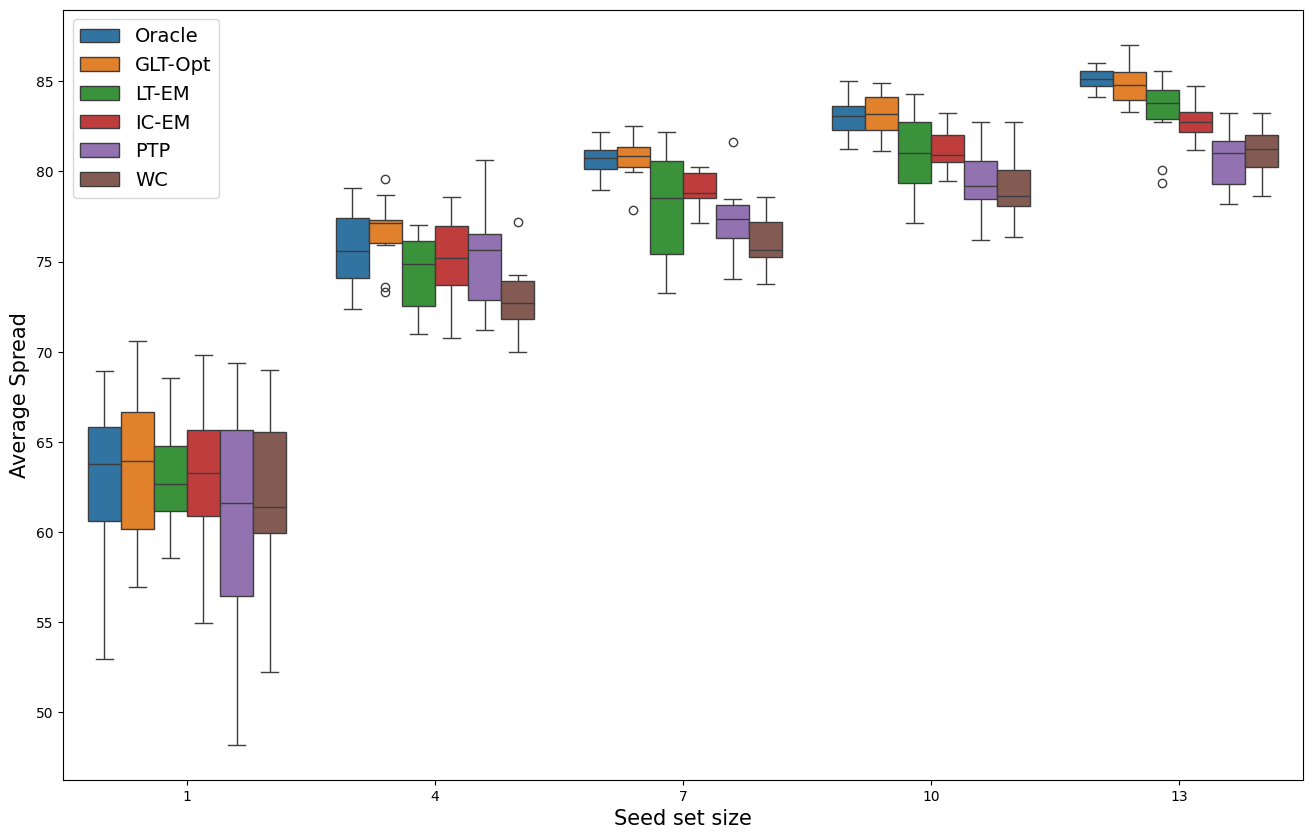

In [10]:

plt.figure(figsize=(16, 10))
sns.boxplot(x=res_df["n_seeds"],
           y=res_df["avg_spread"],
           hue=res_df["Model"])
plt.legend(fontsize=14)
plt.ylabel("Average Spread", fontsize=15)
plt.xlabel("Seed set size", fontsize=15)
plt.show()

In [ ]:
make_heatmap(make_set_intersection_table(greedy_seeds_dict.valus()), greedy_seeds_dict.keys())